# Transfer learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

plt.style.use("ggplot")

# 数据预处理

使用`image_dataset_from_directory`辅助函数来创建数据集。

图像必须以标准化格式存储，例如：

dataset_root_dir/
  - class_a/
    - 00001.png
    - 00002.png
  - class_b/
    - 00001.png
    - 00002.png
  - class_c/
    - 00001.png
    - 00002.png

In [2]:
image_height = 224
image_width = 224

train_set = tf.keras.utils.image_dataset_from_directory(
    directory="../data/train",
    batch_size=32,
    image_size=(image_height, image_width),
    validation_split=0,
    seed=123
)

val_set = tf.keras.utils.image_dataset_from_directory(
    directory="../data/validation/",
    batch_size=32,
    image_size=(image_height, image_width),
)

test_set = tf.keras.utils.image_dataset_from_directory(
    directory="../data/test",
    batch_size=32,
    image_size=(image_height, image_width)
)

Found 3114 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.


2023-10-29 22:57:40.059430: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-29 22:57:40.059464: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-29 22:57:40.059474: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-29 22:57:40.059541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-29 22:57:40.059767: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
class_names = train_set.class_names
print(class_names)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


# 加载预训练模型

In [6]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(image_height, image_width, 3),  # shape of input image
    include_top=False,  # final classificattion layer of pretrained model is not included
    weights="imagenet"  # model should be initialized with weights from imagenet
)

9406464/9406464 [==============================] - 2s 0us/step


# 冻结基础模型

不需要重新训练，保留预训练模型的所有权重。

In [7]:
base_model.trainable = False  # freeze the weights of the pretrained model

# 添加分类头

In [9]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset=-1, input_shape=(image_height, image_width, 3)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes)
])

# 编译模型

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 36)                46116     
                                                                 
Total params: 2304100 (8.79 MB)
Trainable params: 46116 (180.14 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


# 训练模型

In [13]:
epochs = 10
history = model.fit(
    train_set, validation_data=val_set, epochs=epochs
)

Epoch 1/10


2023-10-29 23:19:42.874498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 46s 385ms/step - loss: 1.6654 - accuracy: 0.5658 - val_loss: 0.5496 - val_accuracy: 0.8632
Epoch 2/10
98/98 [==============================] - 25s 241ms/step - loss: 0.5911 - accuracy: 0.8462 - val_loss: 0.3463 - val_accuracy: 0.9145
Epoch 3/10
98/98 [==============================] - 25s 240ms/step - loss: 0.4081 - accuracy: 0.8931 - val_loss: 0.2699 - val_accuracy: 0.9402
Epoch 4/10
98/98 [==============================] - 25s 239ms/step - loss: 0.3079 - accuracy: 0.9245 - val_loss: 0.2311 - val_accuracy: 0.9487
Epoch 5/10
98/98 [==============================] - 25s 240ms/step - loss: 0.2416 - accuracy: 0.9409 - val_loss: 0.2040 - val_accuracy: 0.9573
Epoch 6/10
98/98 [==============================] - 25s 240ms/step - loss: 0.1959 - accuracy: 0.9583 - val_loss: 0.1911 - val_accuracy: 0.9630
Epoch 7/10
98/98 [==============================] - 25s 240ms/step - loss: 0.1645 - accuracy: 0.9666 - val_loss: 0.1766 - val_accuracy: 0.9630
Epoch 8/10

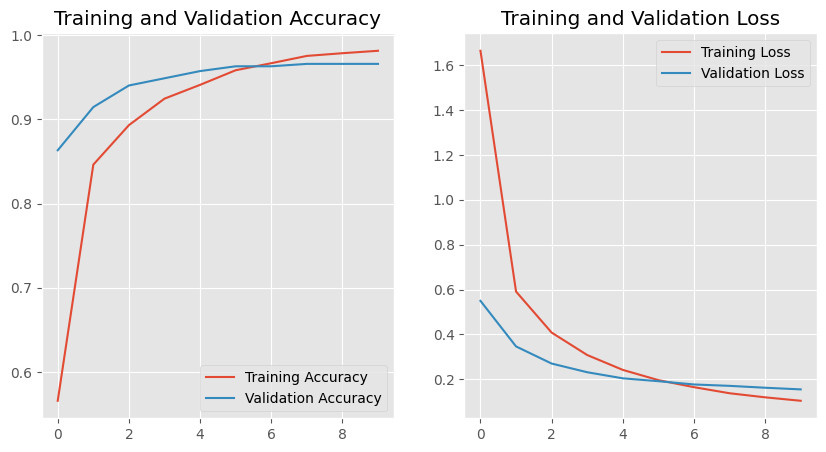

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 评估模型

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate(test_set)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2%}")

12/12 [==============================] - 8s 514ms/step - loss: 0.1550 - accuracy: 0.9666
Loss: 0.15
Accuracy: 96.66%
